In [7]:
#importing the necessary libaries
from root_pandas import read_root
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, precision_score, recall_score
from vectors import Point, Vector
from numpy import array
import gc ; gc.enable()
from math import sqrt, atan2, cos, sin, acos, degrees, log, pi, sinh
from skhep.math.vectors import Vector3D, LorentzVector

In [8]:
#defining the necessary column names to import in
cols = ["TwoBody_M",
"TwoBody_PE",
"TwoBody_PX",
"TwoBody_PY",
"TwoBody_PZ",
"TwoBody_ENDVERTEX_X",
"TwoBody_ENDVERTEX_Y",
"TwoBody_ENDVERTEX_Z",
"TwoBody_OWNPV_X",
"TwoBody_OWNPV_Y",
"TwoBody_OWNPV_Z"
]

extra = ['TwoBody_Extra_Px',
'TwoBody_Extra_Py',
'TwoBody_Extra_Pz',
'TwoBody_Extra_TRUEPID',
'TwoBody_Extra_FromSameB',
'TwoBody_Extra_CHARGE',
'TwoBody_Extra_NNp',
 'TwoBody_Extra_NNk',
 'TwoBody_Extra_NNpi',
 'TwoBody_Extra_NNmu',
 'TwoBody_Extra_NNe']

target = ['TwoBody_FromSameB', 'SignalB_ID']

In [9]:
#read in necessary branches for analysis
df = read_root('TaggingJpsiK2012_tiny_fix_fix.root', columns=cols+target+extra, flatten = extra ).query('TwoBody_Extra_FromSameB==1')

In [10]:
#setting up variable for calculation
B_M_nominal = 5279.5

In [11]:
#set up flight related vectors
df['pv_vector'] = df.apply(lambda x: array([x.TwoBody_OWNPV_X, x.TwoBody_OWNPV_Y, x.TwoBody_OWNPV_Z]), axis=1)
df['sv_vector'] = df.apply(lambda x: array([x.TwoBody_ENDVERTEX_X, x.TwoBody_ENDVERTEX_Y, x.TwoBody_ENDVERTEX_Z]), axis=1)
df['flight'] = df.apply(lambda x: x.sv_vector -x.pv_vector , axis=1)

In [12]:
#defining a function to find the perpendicular vector to our flight vector
def perp(v):
    if v[0] == 0 and v[1] == 0:
        if v[2] == 0:
            raise ValueError('zero vector')
        else:
            return np.cross(v, [0, 1, 0])
    return np.cross(v, [0, 0, 1])

mag = lambda x: np.sqrt(x.dot(x))

In [13]:
df['tan_theta'] = df.apply(lambda x: mag(perp(x.flight)/x.flight[-1]) , axis=1)

In [14]:
#in the C++ code, the variable extra_track_p4 is called p4Track1
df['p4B'] = df.apply(lambda x: LorentzVector(x.TwoBody_PX, x.TwoBody_PY, x.TwoBody_PZ, x.TwoBody_PE), axis=1)

In [15]:
#basically I have to define this function as the function in the libary I'm using doesnt output the four vector but updates the parameters which messes up the .apply method
def setpxpypzm(px, py, pz, m):
        """Set the px,py,pz components and the mass."""
        self = LorentzVector()
        self.x = px; self.y = py; self.z = pz
        if m > 0.:
            self.t = sqrt(px**2 + py**2 + pz**2 + m**2)
        else:
            self.t = sqrt(px**2 + py**2 + pz**2 - m**2)
        
        return self

In [16]:
PID_table = pd.Series(data= [938.27, 493.677, 139.57, 0.511, 105.658], 
          index= ['TwoBody_Extra_NNp', 'TwoBody_Extra_NNk', 'TwoBody_Extra_NNpi', 'TwoBody_Extra_NNe', 'TwoBody_Extra_NNmu' ])

def mass_hypothesis_pred(x):
    rows_PID = x.loc[PID_table.index]
    idx_PID = [idx for idx in PID_table.index if x[idx] == rows_PID.max()]
    mass_PID = PID_table.loc[idx_PID]
    p4_vector = setpxpypzm(x.TwoBody_Extra_Px, x.TwoBody_Extra_Py, x.TwoBody_Extra_Pz, mass_PID[0])
    return p4_vector

df['extra_track_p4'] = df.apply(mass_hypothesis_pred ,axis=1)

In [18]:
#PT estimate based on reconstructed mass and flight vector
df['pt_est'] = df.apply(lambda x: (B_M_nominal/x.TwoBody_M)*x.tan_theta*x.TwoBody_PZ, axis=1)

In [19]:
#for some reason, the libary I used, only allowed calcualtion of eta for lorentz vectors and not Vector3D as well, so I made my own
def eta(Vector3D):
        """Return the pseudorapidity."""
        if abs(Vector3D.costheta()) < 1.:
            return -0.5 * log( (1. - Vector3D.costheta())/(1. + Vector3D.costheta()) )
        else:
            return 10E10 if Vector3D.z > 0 else -10E10

In [20]:
#calculating the eta and phi of the flight vector
df['flight_eta'] = df.apply(lambda x: eta(Vector3D(x.flight[0], x.flight[1], x.flight[2]).unit()), axis=1)
df['flight_phi'] = df.apply(lambda x: Vector3D(x.flight[0], x.flight[1], x.flight[2]).unit().phi(), axis=1) 

In [21]:
#my version of the SetPtEtaPhiM function
def my_SetPtEtaPhiM(pt, eta, phi, m):
        """ Set the transverse momentum, the pseudorapidity, the angle phi and the mass."""
        px, py, pz = pt*cos(phi), pt*sin(phi), pt*sinh(eta)
        
        self = LorentzVector()
        self.x = px; self.y = py; self.z = pz
        if m > 0.:
            self.t = sqrt(px**2 + py**2 + pz**2 + m**2)
        else:
            self.t = sqrt(px**2 + py**2 + pz**2 - m**2)
        
        return self

In [22]:
#estimated B candidate for this estimated momentum, measured flight direction and expected true B mass
df['p4B_est'] = df.apply(lambda x: my_SetPtEtaPhiM(x.pt_est, x.flight_eta, x.flight_phi, B_M_nominal), axis=1)

In [23]:
def boostvector(self):
        """Return the spatial component divided by the time component."""
        return Vector3D(self.x / self.t, self.y / self.t, self.z / self.t)

In [24]:
df['boost_est'] = df.apply(lambda x: boostvector(x.p4B_est), axis=1)

In [25]:
def minus_vector(v):
    "This is because I need to boost by -boost_est and not boost_est in step below"
    minus_v = Vector3D()
    minus_v.x = -v.x; minus_v.y = -v.y; minus_v.z = -v.z
    return minus_v

In [26]:
df['extra_track_p4_boosted'] = df.apply(lambda x: x.extra_track_p4.boost(x.boost_est),axis=1)

In [27]:
#missing mass^2 - this can go negative with resolution
df['mm2'] = df.apply(lambda x: (x.p4B_est - x.p4B).mass2, axis=1)

In [28]:
df['Etrack_extra'] = df.apply(lambda x: x.extra_track_p4_boosted.t, axis=1)

In [29]:
df4analysis = df.query('TwoBody_FromSameB==1')
cols4analysis =  ['SignalB_ID' , 'TwoBody_Extra_TRUEPID', 'Etrack_extra', 'TwoBody_Extra_CHARGE' ]
df4analysis = df4analysis.loc[:, cols4analysis]
df4analysis['TwoBody_Extra_CHARGE*SignalB_ID'] = df4analysis.apply(lambda x: x.TwoBody_Extra_CHARGE*x.SignalB_ID, axis=1)

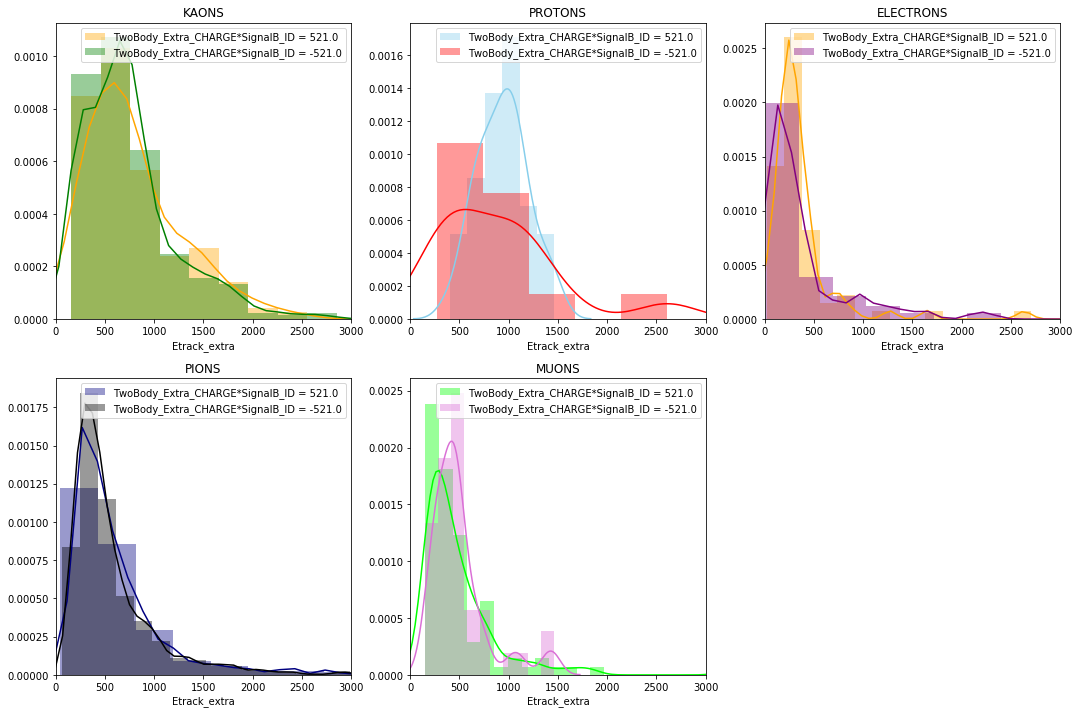

In [41]:
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
#plt.figure(figsize=(8,8))
plt.title('KAONS')
plt.xlim(0, 3000)
data = df4analysis.query('TwoBody_Extra_TRUEPID==321').query('Etrack_extra < 20000')
dist1 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == 521.0').Etrack_extra
dist2 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == -521.0').Etrack_extra
sns.distplot(dist1, color="orange", label = 'TwoBody_Extra_CHARGE*SignalB_ID = 521.0')
sns.distplot(dist2, color="green", label = 'TwoBody_Extra_CHARGE*SignalB_ID = -521.0')
plt.legend()

plt.subplot(2,3,2)
plt.title('PROTONS')
plt.xlim(0, 3000)
data = df4analysis.query('TwoBody_Extra_TRUEPID==2212').query('Etrack_extra < 5000')
dist1 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == 521.0').Etrack_extra
dist2 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == -521.0').Etrack_extra
sns.distplot(dist1, color="skyblue", label = 'TwoBody_Extra_CHARGE*SignalB_ID = 521.0')
sns.distplot(dist2, color="red", label = 'TwoBody_Extra_CHARGE*SignalB_ID = -521.0')
plt.legend()

plt.subplot(2,3,3)
plt.title('ELECTRONS')
plt.xlim(0,3000)
data = df4analysis.query('TwoBody_Extra_TRUEPID==11')
dist1 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == 521.0').Etrack_extra
dist2 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == -521.0').Etrack_extra
sns.distplot(dist1, color="orange", label = 'TwoBody_Extra_CHARGE*SignalB_ID = 521.0')
sns.distplot(dist2, color="purple", label = 'TwoBody_Extra_CHARGE*SignalB_ID = -521.0')
plt.legend()

plt.subplot(2,3,4)
plt.title('PIONS')
plt.xlim(0, 3000)
data = df4analysis.query('TwoBody_Extra_TRUEPID==211').query('Etrack_extra < 20000')
dist1 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == 521.0').Etrack_extra
dist2 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == -521.0').Etrack_extra
sns.distplot(dist1, color="navy", label = 'TwoBody_Extra_CHARGE*SignalB_ID = 521.0')
sns.distplot(dist2, color="black", label = 'TwoBody_Extra_CHARGE*SignalB_ID = -521.0')
plt.legend()

plt.subplot(2,3,5)
plt.title('MUONS')
plt.xlim(0, 3000)
data = df4analysis.query('TwoBody_Extra_TRUEPID==13').query('Etrack_extra < 20000')
dist1 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == 521.0').Etrack_extra
dist2 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == -521.0').Etrack_extra
sns.distplot(dist1, color="lime", label = 'TwoBody_Extra_CHARGE*SignalB_ID = 521.0')
sns.distplot(dist2, color="orchid", label = 'TwoBody_Extra_CHARGE*SignalB_ID = -521.0')
plt.legend()

(47, 5)


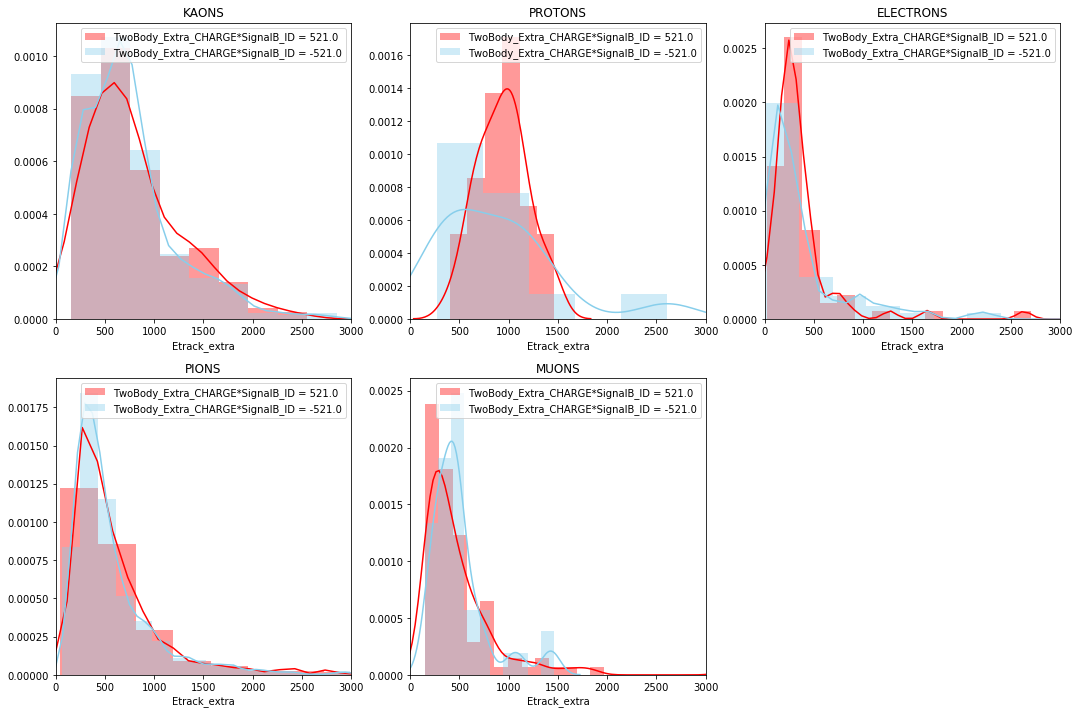

In [42]:
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
#plt.figure(figsize=(8,8))
plt.title('KAONS')
plt.xlim(0, 3000)
data = df4analysis.query('TwoBody_Extra_TRUEPID==321').query('Etrack_extra < 20000')
dist1 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == 521.0').Etrack_extra
dist2 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == -521.0').Etrack_extra
sns.distplot(dist1, color="red", label = 'TwoBody_Extra_CHARGE*SignalB_ID = 521.0')
sns.distplot(dist2, color="skyblue", label = 'TwoBody_Extra_CHARGE*SignalB_ID = -521.0')
plt.legend()

plt.subplot(2,3,2)
plt.title('PROTONS')
plt.xlim(0, 3000)
data = df4analysis.query('TwoBody_Extra_TRUEPID==2212').query('Etrack_extra < 5000')
print(data.shape)
dist1 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == 521.0').Etrack_extra
dist2 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == -521.0').Etrack_extra
sns.distplot(dist1, color="red", label = 'TwoBody_Extra_CHARGE*SignalB_ID = 521.0')
sns.distplot(dist2, color="skyblue", label = 'TwoBody_Extra_CHARGE*SignalB_ID = -521.0')
plt.legend()

plt.subplot(2,3,3)
plt.title('ELECTRONS')
plt.xlim(0,3000)
data = df4analysis.query('TwoBody_Extra_TRUEPID==11')
dist1 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == 521.0').Etrack_extra
dist2 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == -521.0').Etrack_extra
sns.distplot(dist1, color="red", label = 'TwoBody_Extra_CHARGE*SignalB_ID = 521.0')
sns.distplot(dist2, color="skyblue", label = 'TwoBody_Extra_CHARGE*SignalB_ID = -521.0')
plt.legend()

plt.subplot(2,3,4)
plt.title('PIONS')
plt.xlim(0, 3000)
data = df4analysis.query('TwoBody_Extra_TRUEPID==211').query('Etrack_extra < 20000')
dist1 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == 521.0').Etrack_extra
dist2 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == -521.0').Etrack_extra
sns.distplot(dist1, color="red", label = 'TwoBody_Extra_CHARGE*SignalB_ID = 521.0')
sns.distplot(dist2, color="skyblue", label = 'TwoBody_Extra_CHARGE*SignalB_ID = -521.0')
plt.legend()

plt.subplot(2,3,5)
plt.title('MUONS')
plt.xlim(0, 3000)
data = df4analysis.query('TwoBody_Extra_TRUEPID==13').query('Etrack_extra < 20000')
dist1 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == 521.0').Etrack_extra
dist2 = data.query('TwoBody_Extra_CHARGE*SignalB_ID == -521.0').Etrack_extra
sns.distplot(dist1, color="red", label = 'TwoBody_Extra_CHARGE*SignalB_ID = 521.0')
sns.distplot(dist2, color="skyblue", label = 'TwoBody_Extra_CHARGE*SignalB_ID = -521.0')
plt.legend()

In [45]:
df.query('TwoBody_Extra_TRUEPID==2212').shape

(165, 39)

In [224]:
#read in necessary branches for analysis
test = read_root('TaggingJpsiK2012_tiny.root')

/home/colmsam/miniconda/envs/cern_env/lib/python3.7/site-packages/root_pandas/readwrite.py:320: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = df.reindex_axis(columns, axis=1, copy=False)


In [225]:
[c for c in test.columns ]

['Head_ENDVERTEX_X',
 'Head_ENDVERTEX_Y',
 'Head_ENDVERTEX_Z',
 'Head_ENDVERTEX_XERR',
 'Head_ENDVERTEX_YERR',
 'Head_ENDVERTEX_ZERR',
 'Head_ENDVERTEX_CHI2',
 'Head_ENDVERTEX_NDOF',
 'Head_ENDVERTEX_COV_',
 'Head_OWNPV_X',
 'Head_OWNPV_Y',
 'Head_OWNPV_Z',
 'Head_OWNPV_XERR',
 'Head_OWNPV_YERR',
 'Head_OWNPV_ZERR',
 'Head_OWNPV_CHI2',
 'Head_OWNPV_NDOF',
 'Head_OWNPV_COV_',
 'Head_IP_OWNPV',
 'Head_IPCHI2_OWNPV',
 'Head_FD_OWNPV',
 'Head_FDCHI2_OWNPV',
 'Head_DIRA_OWNPV',
 'Head_P',
 'Head_PT',
 'Head_PE',
 'Head_PX',
 'Head_PY',
 'Head_PZ',
 'Head_MM',
 'Head_MMERR',
 'Head_M',
 'SignalB_ENDVERTEX_X',
 'SignalB_ENDVERTEX_Y',
 'SignalB_ENDVERTEX_Z',
 'SignalB_ENDVERTEX_XERR',
 'SignalB_ENDVERTEX_YERR',
 'SignalB_ENDVERTEX_ZERR',
 'SignalB_ENDVERTEX_CHI2',
 'SignalB_ENDVERTEX_NDOF',
 'SignalB_ENDVERTEX_COV_',
 'SignalB_OWNPV_X',
 'SignalB_OWNPV_Y',
 'SignalB_OWNPV_Z',
 'SignalB_OWNPV_XERR',
 'SignalB_OWNPV_YERR',
 'SignalB_OWNPV_ZERR',
 'SignalB_OWNPV_CHI2',
 'SignalB_OWNPV_NDOF',
 'Si